# Analysis of CLIP similarities on one movie

In [1]:
import sys
sys.path.append("/home/simon/mount/astranaar/moment_detr")
import os
from IPython.utils import io
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.manifold import TSNE
from tqdm import tqdm
import pickle
from sklearn.decomposition import PCA

import torch
from torch.nn import functional as F

from moment_detr.config import BaseOptions
from moment_detr.transformer import build_transformer
from moment_detr.position_encoding import build_position_encoding
from moment_detr.clip_similarity import clip_filter_proposals
from moment_detr.setup_clip_training import setup_training, set_seed, data_to_device
from moment_detr.clip_decoder_inference import sort_spans



In [2]:
with io.capture_output() as captured:
    opt = BaseOptions()
    opt.initialize()
    opt = opt.parse()
local_root = '/home/simon/data/'
remote_root = '/home/simon/mount/data/'

opt.train_path = os.path.join(local_root, 'mad_dataset/annotations/MAD_train.json')
opt.eval_path_long_nlq = os.path.join(local_root, 'mad_dataset/annotations/MAD_test.json')
opt.eval_path = os.path.join(local_root, 'mad_dataset/annotations/MAD_val.json')
opt.t_feat_dir = os.path.join(local_root, 'mad_dataset/')
opt.v_feat_dirs = [os.path.join(local_root, 'mad_dataset/')]
opt.resume = os.path.join(remote_root, 'mad_dataset/momentDETR_results/CLIP_L14_bsz128_lr4e-4_lrd15_dr1_wl30_smonline_fps5_lws4_lloss4_reduce_plateau/model_best.ckpt')
opt.concat_sims = False
opt.max_q_l = 100
opt.cuda_visible_devices=[0]

model, criterion, optimizer, lr_scheduler, opt, train_loader, val_loader = setup_training(mode='train', opt=opt, batch_size=1, num_workers=0,use_clip_prefiltering=False)
dataloader = iter(train_loader)

2023-01-23 17:09:55.028:INFO:moment_detr.inference - setup model/optimizer/scheduler
2023-01-23 17:09:55.831:INFO:moment_detr.inference - CUDA enabled.
2023-01-23 17:09:55.840:INFO:moment_detr.inference - Load checkpoint from /home/simon/mount/data/mad_dataset/momentDETR_results/CLIP_L14_bsz128_lr4e-4_lrd15_dr1_wl30_smonline_fps5_lws4_lloss4_reduce_plateau/model_best.ckpt
2023-01-23 17:09:56.041:INFO:moment_detr.setup_clip_training - Model MomentDETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, element

Parameter Count: all 4,378,377; trainable 4,378,377


2023-01-23 17:09:58.240:INFO:moment_detr.long_nlq_dataset - LOADING: /home/simon/data/mad_dataset/CLIP_L14_language_tokens_features.h5
2023-01-23 17:09:58.242:INFO:moment_detr.long_nlq_dataset - LOADING: /home/simon/data/mad_dataset/CLIP_L14_frames_features_5fps.h5
2023-01-23 17:09:58.242:INFO:moment_detr.long_nlq_dataset - LOADING: /home/simon/data/mad_dataset/annotations/MAD_val.json


In [3]:
batch = next(dataloader)
target, data, qid, windows = batch
clip_metrics = {}
_data, _target, windows, metrics, sims = clip_filter_proposals(data[0],target[0],7,300,clip_metrics,windows[0],-1)
movie = data[0]['src_vid']
topk_movie = _data['src_vid']
topk_target = _target

t = topk_target['is_foreground'].argmax().item()
rounded_frames_idx = [round(t*5) for t in target[0]['anno']['ext_timestamps']]

start_end_relative_to_window = [r-w for r,w in zip(rounded_frames_idx, windows[t])]
middle_frame = int(np.mean(rounded_frames_idx) -rounded_frames_idx[0])
start_end_frames = [_data['src_vid'][t][i] for i in start_end_relative_to_window]
middle_frame = _data['src_vid'][t][middle_frame]

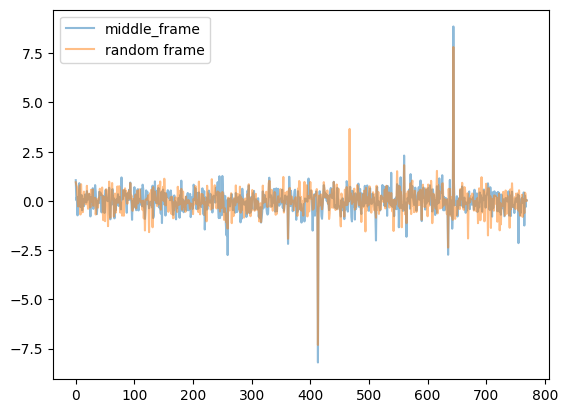

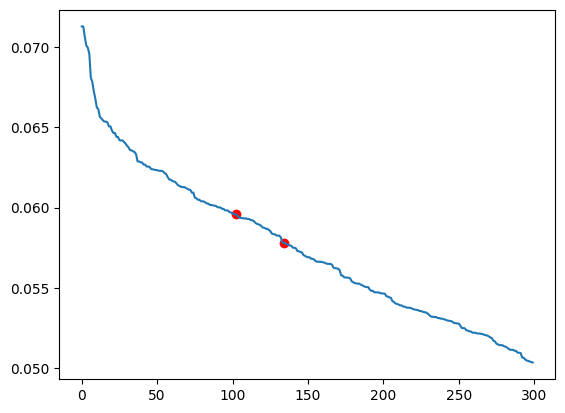

In [4]:
#labels = ['start frame','end frame', 'middle_frame', 'random frame']
labels = ['middle_frame', 'random frame']
for idx, frame in enumerate([middle_frame, _data['src_vid'][20][0]]):
    plt.plot(frame, label = labels[idx], alpha=0.5)
plt.legend(), plt.show()

plt.plot(sims)
for t in torch.where(topk_target['is_foreground']==1)[0]:
    plt.scatter(t, sims[t], c='red')
plt.show()

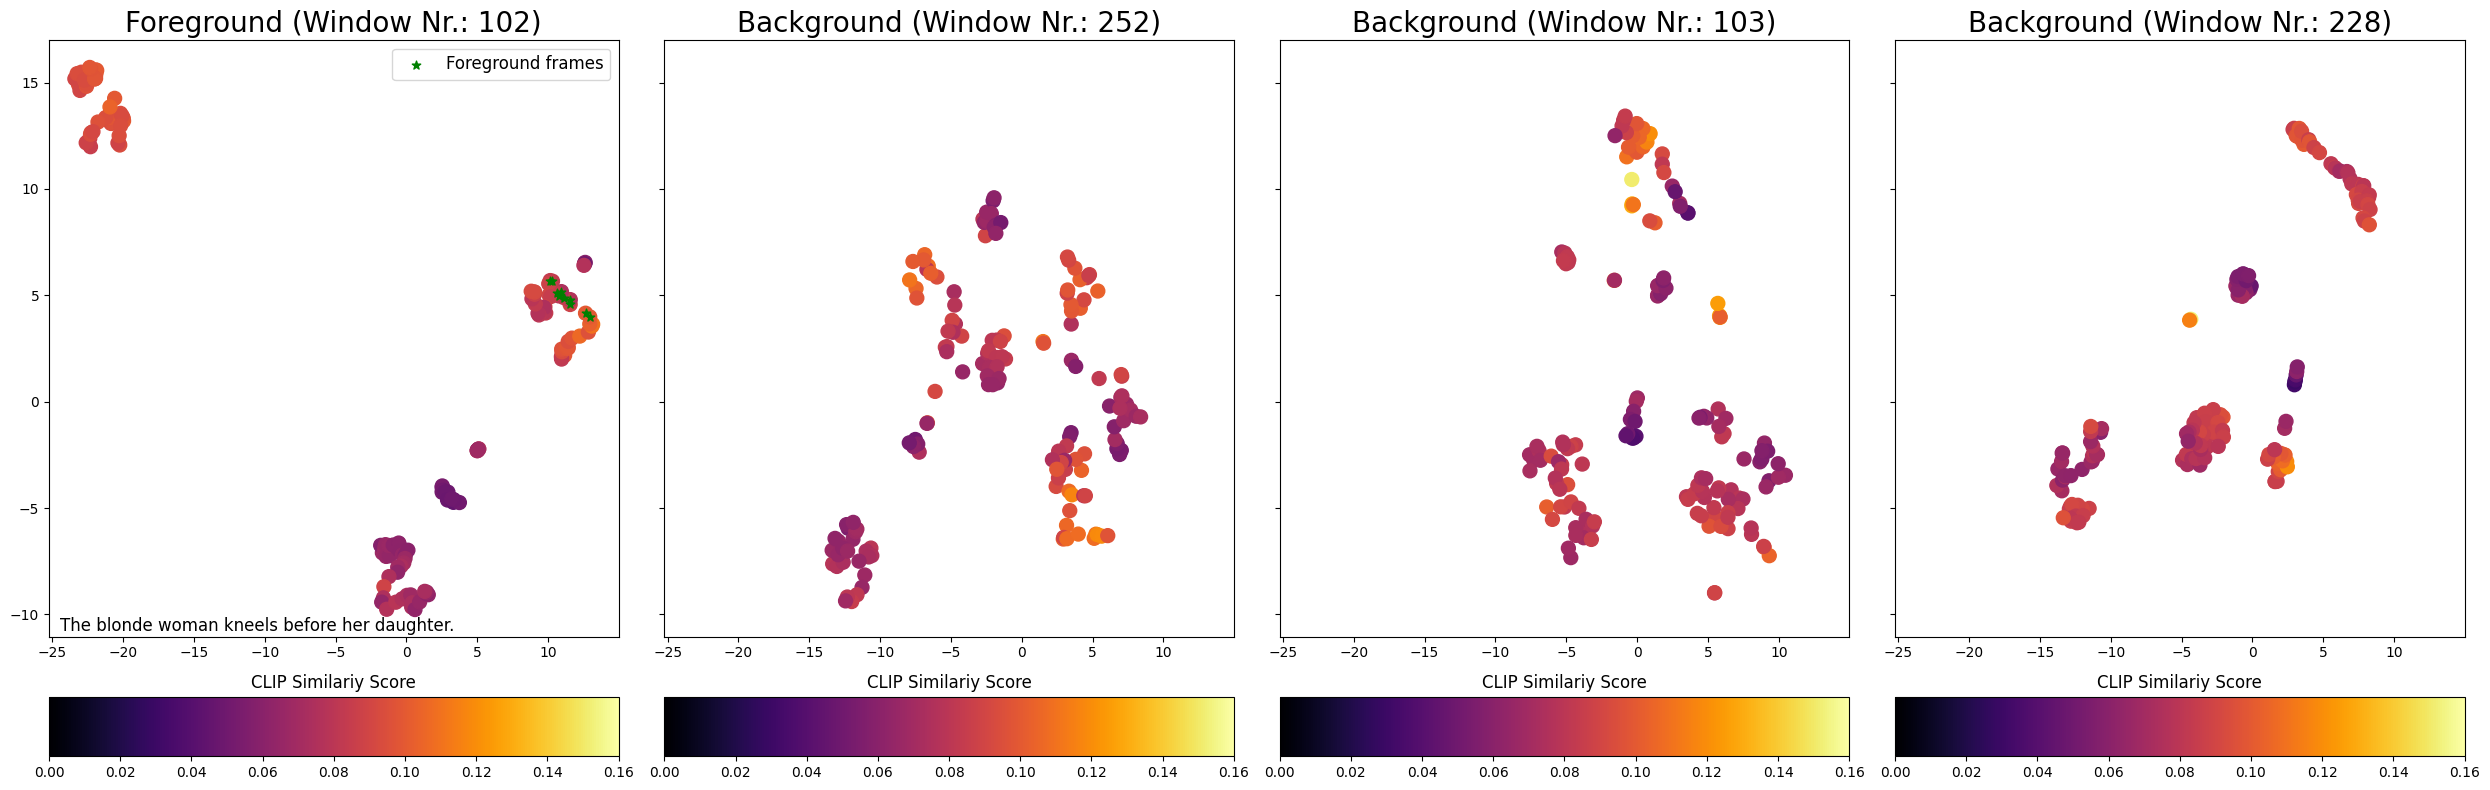

In [5]:
foreground_window_idx = topk_target['is_foreground'].argmax().item()
background_window_idx = [np.random.choice(torch.where(topk_target['is_foreground']==0)[0]) for _ in range(3)]

sentence = target[0]['anno']['sentence']
line_break = 10
words = sentence.split()
sentence = [words[i] + ('\n' if (i+1) % line_break == 0 else ' ') for i in range(len(words))]
sentence = ''.join(sentence)

tsne = TSNE(n_components=2)
pca = PCA(n_components=50)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 8), sharey=True, sharex=True)

for idx, ax, title in zip([foreground_window_idx] + background_window_idx, (ax1, ax2, ax3, ax4), ['Foreground']+['Background']*3):

    text = data[0]['src_txt'][idx,-1].unsqueeze(0)
    frames = data[0]['src_vid'][idx][...,:-2]
    sims = text @ frames.T
    sims = sims / sims.norm(dim=-1, keepdim=True)
    # sims.shape = (1,150)

    # Perform t-SNE on the flattened data
    with io.capture_output():
        movie_reduced = pca.fit_transform(topk_movie[idx])
        data_tsne = tsne.fit_transform(movie_reduced)

    # Plot the t-SNE output
    foreground_dot = ax.scatter(data_tsne[:, 0], data_tsne[:, 1], c=sims, s=100, vmin=0, vmax=0.16, cmap='inferno')
    if title=='Foreground':
        data_fg = data_tsne[start_end_relative_to_window[0]:start_end_relative_to_window[1]]
        ax.scatter(data_fg[:, 0], data_fg[:, 1],marker='*',c='g', s=40, label = 'Foreground frames')
        ax.legend(fontsize=12)
        ax.text(0.02, 0.01, sentence, fontsize=12, transform=ax.transAxes)


    ax.set_title(f'{title} (Window Nr.: {idx})', fontsize=20)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='10%', pad=0.6)
    #cax.set_xlabel('data label')  # cax == cb.ax

    clb = plt.colorbar(foreground_dot, ax=ax, cax=cax, orientation='horizontal')
    clb.ax.set_title('CLIP Similariy Score',fontsize=12)

    
plt.tight_layout()


In [6]:
def load_batches():
    sentences = ['SOMEONE looks at SOMEONE', 'SOMEONE looking at SOMEONE', 'He looks at SOMEONE', 'She looks at SOMEONE']

    batches, clip_batches = [],[]
    for batch in tqdm(train_loader):
        target, data, qid, windows = batch
        if any([s in target[0]['anno']['sentence'] for s in sentences]):
            print('Sentence:' + target[0]['anno']['sentence'])
            clip_metrics = {}
            batches.append(batch)
            clip_batches.append(clip_filter_proposals(data[0],target[0],7,100,clip_metrics,windows[0],-1))
        if len(batches)==10:
            break



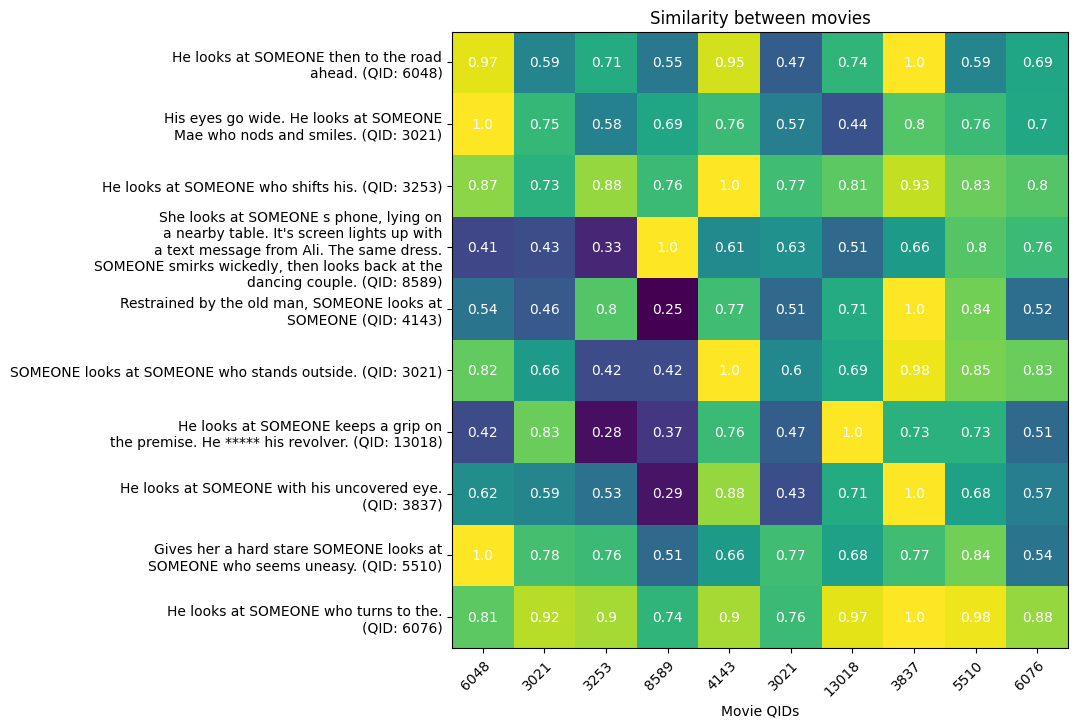

In [7]:
load_batches = True

if load_batches:
    with open(f'{local_root}notebooks/batches.pkl', 'rb') as f:
        batches = pickle.load(f)
else:
    batches, clip_batches = load_batches()


sentences = [b[0][0]["anno"]["sentence"] for b in batches]
movies = [b[0][0]["anno"]["movie"] for b in batches]

for sentence_idx, sentence in enumerate(sentences):
    line_break = 8
    words = sentence.split()
    sentence = [words[i] + ('\n' if (i+1) % line_break == 0 else ' ') for i in range(len(words))]
    sentences[sentence_idx] = ''.join(sentence)
    sentences[sentence_idx] += f'(QID: {movies[sentence_idx]})'


similarity, middle_frames, outer_frames = {}, [], []
for cnt, batch in enumerate(batches):

    batch_sims = []
    target, data, qid, windows = batch

    foreground_window_idx = target[0]['is_foreground'].argmax().item()
    text = data[0]["src_txt"][foreground_window_idx, -1].unsqueeze(0)


    for inner_data in batches:
        
        foreground_window_idx = inner_data[0][0]['is_foreground'].argmax().item()
        rounded_frames_idx = [round(t*5) for t in target[0]['anno']['ext_timestamps']]
        start_end_relative_to_window = [r-w for r,w in zip(rounded_frames_idx, windows[0][foreground_window_idx])]
        middle_frame_idx = int(np.mean(rounded_frames_idx) -rounded_frames_idx[0])

        inner_frames = inner_data[1][0]['src_vid'][foreground_window_idx][..., :-2]
        middle_frame = inner_frames[middle_frame_idx].unsqueeze(0)

        if cnt==0:
            middle_frames.append(middle_frame)
            outer_frames.append(inner_data[1][0]['src_vid'][50][0, :-2].unsqueeze(0))

        sims = text @ middle_frame.T
        batch_sims.append(sims.item())
    
    similarity[str(cnt)] = batch_sims

for key in similarity.keys():
    similarity[key] = [s / max(similarity[key]) for s in similarity[key]]


similarity = {k: [round(vv, 2) for vv in v] for k, v in similarity.items()}
fig, ax = plt.subplots(figsize=(8,8))

im = ax.imshow(np.array(list(similarity.values())))
ax.set_xticks(np.arange(len(similarity)))
ax.set_yticks(np.arange(len(similarity)))
ax.set_xticklabels(movies)
ax.set_yticklabels(sentences)
ax.set_xlabel('Movie QIDs')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
for i in range(len(similarity)):
    for j in range(len(similarity)):
        text = ax.text(j, i, similarity[list(similarity.keys())[i]][j],
                        ha="center", va="center", color="w")
ax.set_title("Similarity between movies")
plt.show()


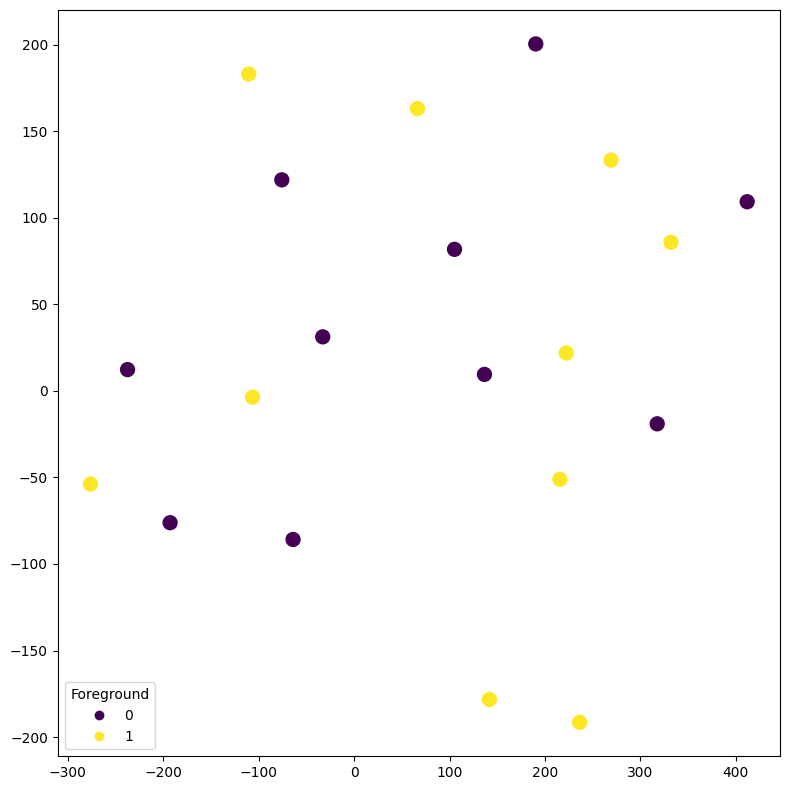

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

pca = PCA(n_components=20)

middle_frames_stacked = torch.cat(middle_frames,dim=0)
outer_frames_stacked = torch.cat(outer_frames,dim=0)
frames_stacked = torch.cat([middle_frames_stacked,outer_frames_stacked],dim=0)
inds = [1 for i in range(middle_frames_stacked.shape[0])] + [0 for i in range(outer_frames_stacked.shape[0])]

frames_stacked = pca.fit_transform(frames_stacked)

# Perform t-SNE on the flattened data
with io.capture_output():
    tsne = TSNE(n_components=2, perplexity = 10)
    data_tsne = tsne.fit_transform(frames_stacked)


# Plot the t-SNE results
foreground_dot = ax.scatter(data_tsne[:, 0], data_tsne[:, 1], cmap='viridis', s=100, c=inds)
#add legend
ax.legend(*foreground_dot.legend_elements(), loc="lower left", title="Foreground")
    
plt.tight_layout()

In [102]:
preds, targets = {}, {}

for batch in batches:
    target, data, qid, windows = batch
    print(target[0]['anno']['sentence'])
    data_on_gpu = data_to_device(batch[1], opt)
    outputs = model(**data_on_gpu[0])
    prob = F.softmax(outputs["pred_logits"], -1)[..., 0, None]
    spans = sort_spans(0, outputs, windows, prob)

    pred = np.vstack(np.array(spans))
    pred = pred[np.argsort(pred[:, -1])]
    pred = pred[::-1]
    preds[qid[0]] = pred
    targets[qid[0]] = target[0]['anno']['ext_timestamps']

He looks at SOMEONE  then to the road ahead.
His eyes go wide. He looks at SOMEONE Mae who nods and smiles.
He looks at SOMEONE who shifts his.
She looks at SOMEONE s phone, lying on a nearby table. It's screen lights up with a text message from Ali. The same dress. SOMEONE smirks wickedly, then looks back at the dancing couple.
Restrained by the old man, SOMEONE looks at SOMEONE 
 SOMEONE looks at SOMEONE  who stands outside.
He looks at SOMEONE  keeps a grip on the premise. He ***** his revolver.
He looks at SOMEONE with his uncovered eye.
Gives her a hard stare SOMEONE looks at SOMEONE  who seems uneasy.
He looks at SOMEONE  who turns to the.


In [118]:
(hist/hist.max())*80000

array([80000.        ,  5263.15789474,  3157.89473684,  1052.63157895,
        1447.36842105,  1052.63157895,   394.73684211,   921.05263158,
         394.73684211,   263.15789474,   526.31578947,   526.31578947,
         789.47368421,   657.89473684,   131.57894737,   263.15789474,
         526.31578947,   526.31578947,   394.73684211,   657.89473684,
         657.89473684,   394.73684211,   263.15789474,   263.15789474,
         657.89473684,   526.31578947,   263.15789474,   263.15789474,
         921.05263158,   657.89473684,   526.31578947,   526.31578947,
         526.31578947,   921.05263158,   263.15789474,  1052.63157895,
        1052.63157895,   526.31578947,  1315.78947368,  1578.94736842,
        1315.78947368,  1842.10526316,  1315.78947368,  1973.68421053,
        2500.        ,  1447.36842105,  2105.26315789,  1973.68421053,
        3289.47368421,  1710.52631579])

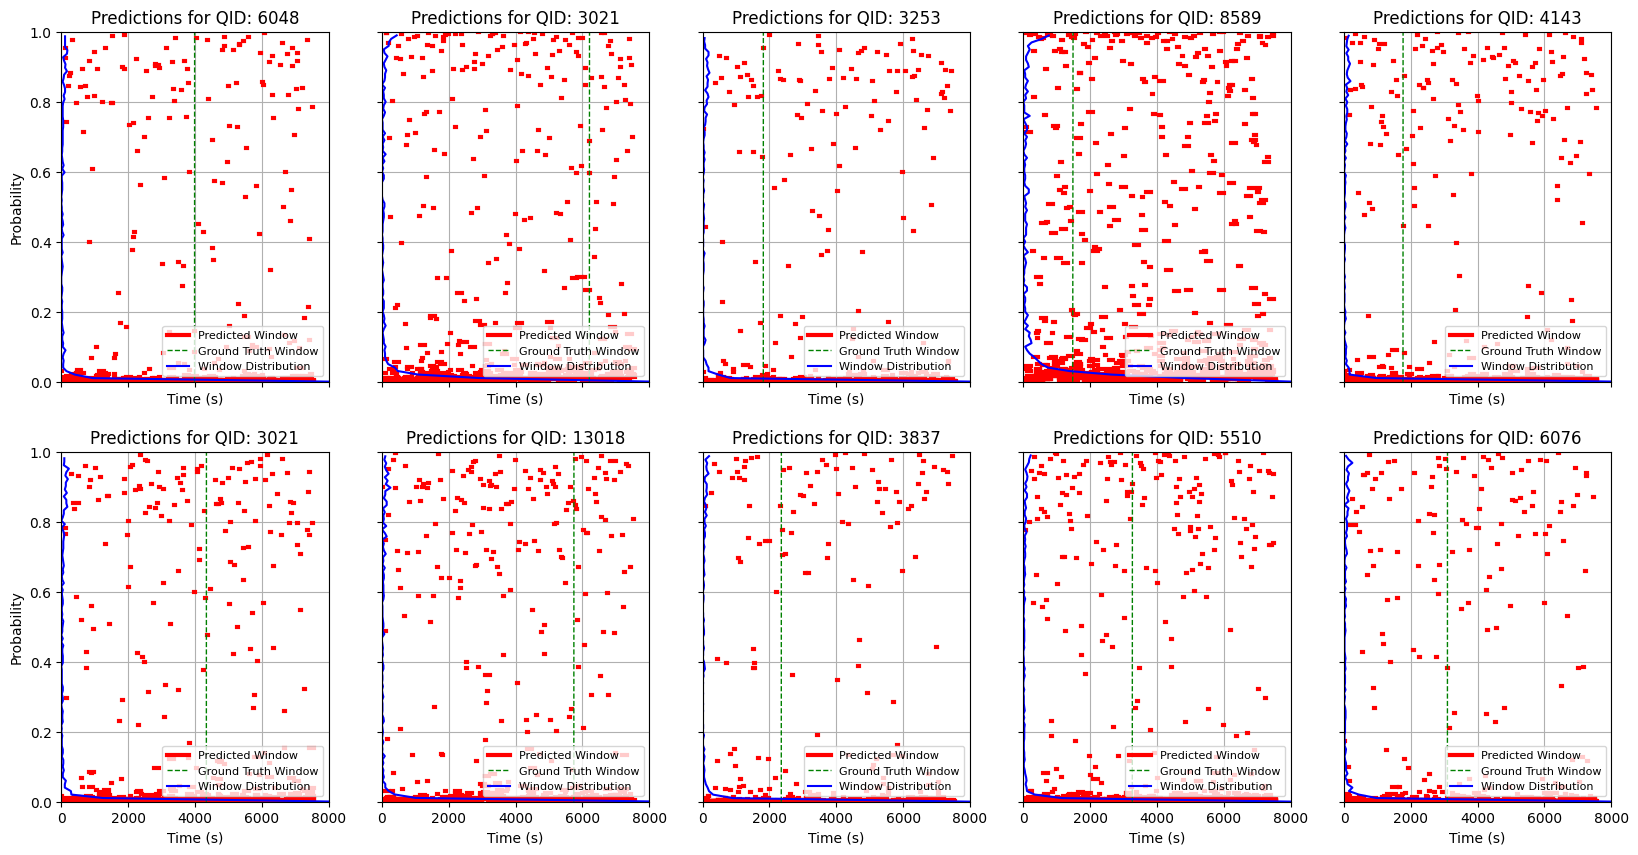

In [129]:
from scipy.stats import gaussian_kde
preds_iter = iter(preds.keys())

rows = 2
columns = 5
y_max = 8000
fig, ax = plt.subplots(2, 5, figsize=(20, 10),sharey=True,sharex=True)

for i in range(rows):
    for j in range(columns):
        key = next(preds_iter)
        span = preds[key]
        start_times = span[:,0]
        end_times = span[:,1]
        probs = span[:,2]

        cnt=0
        for s,e,p in zip(start_times,end_times,probs):
            if cnt==0:
                ax[i,j].plot([s,e], [p,p], color='red', linewidth=3, label='Predicted Window')
                cnt+=1
            else:
                ax[i,j].plot([s,e], [p,p], color='red', linewidth=3)

        ax[i,j].plot(targets[key],[0,1],'--',color='green',linewidth=1, label='Ground Truth Window')

        hist, edges = np.histogram(probs, bins=100)
        hist = (hist/hist.max())*y_max
        ax[i,j].plot(hist, edges[:-1], color = "blue", label='Window Distribution')

        ax[i,j].set_title(f'Predictions for QID: {movies[i*columns+j]}')
        ax[i,j].set_xlabel('Time (s)')
        ax[i,0].set_ylabel('Probability')
        ax[i,j].set_ylim(0,1)
        ax[i,j].set_xlim(0,y_max)
        ax[i,j].grid()
        #put a small legend in the bottom right corner of each subplot
        ax[i,j].legend(loc='lower right', fontsize=8)

plt.show()